In [6]:
from module import *

import gurobipy as gp
from gurobipy import GRB,tuplelist
import scipy.io
import math

import pandas as pd

# Electricity price
price_el = np.array([0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.12, 0.12, 0.14, 0.14, 0.14, 0.14, 0.12, 0.12, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.06, 0.06, 0.06, 0.06, 0.06])

# DG input
dgloc = {'bus':[3,13,22], 'Pmin':[0,0,0], 'Pmax':[0.5,0.5,0.5], 'Qmin':[-0.3,-0.3,-0.3], 'Qmax':[0.3,0.3,0.3]}
gci = [0.55,0.7,0.8,0.75]

# PV input
pvloc = {'bus':[9, 15, 19], 'p_max':[0.3, 0.3, 0.3], 'q_min':[-0.3, -0.3, -0.3], 'q_max':[0.3, 0.3, 0.3]}
# pvloc = {'bus':[15], 'p_max':[0.3], 'q_min':[-0.3], 'q_max':[0.3]}

# ESS input
essloc = {'bus':[7,21,29],'Cap':[1,1,1],'Pmin':[0,0,0],'Pmax':[0.2,0.2,0.2],'Qmin':[-0.15,-0.15,-0.15],'Qmax':[0.15,0.15,0.15]}

# Data preprocessing
# ----------- INPUTS -----------
T = 49
mins = 30
vmin, vmax = 0.95,1.05
# use_mdt = True
seqs = [0]
# ------------------------------
data = IEEE33(T=T,period=mins)
data.loadsys()
data.include_dg(dgloc,gci)
data.include_pv(pvloc)
data.include_ess(essloc)

sets = define_sets(data)

for seq in seqs:
## Power Flow Variables
    m = gp.Model('Case33-Linear')

    u_i = m.addVars(sets.bus_t, vtype=GRB.CONTINUOUS, lb=vmin**2, ub=vmax**2, name='V_squared')

    p_g = m.addVars(sets.gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=data.gen.Pmax.tolist()*T, name='P_Gen')
    q_g = m.addVars(sets.gen_t, vtype=GRB.CONTINUOUS, lb=data.gen.Qmin.tolist()*T, ub=data.gen.Qmax.tolist()*T, name='Q_Gen')

    p_inj = m.addVars(sets.bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='P_Inj')
    q_inj = m.addVars(sets.bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Inj')

    br_lim = 5
    p_ij = m.addVars(sets.line_t, vtype=GRB.CONTINUOUS, lb=-br_lim, ub=br_lim, name='P_Line')
    q_ij = m.addVars(sets.line_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Line')

    l_ij = m.addVars(sets.line_t, vtype=GRB.CONTINUOUS, lb=0, ub=30, name='L_Line')


    neighbors = define_neighbor(sets.bus,sets.line)
    impbase = data.impbase

    
    p_hat = m.addVars(sets.line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=br_lim, name='P_hat')  

    P_balance = m.addConstrs(((p_ij.sum(i,'*',t) + gp.quicksum(data.resi(i,j) * l_ij.sum(i,j,t) for j in neighbors.Neighbors[i])) - p_ij.sum('*',i,t) == p_inj[i,t] for i,t in sets.bus_t), name='P-Balance')
    Q_balance = m.addConstrs(((q_ij.sum(i,'*',t) + gp.quicksum(data.reac(i,j) * l_ij.sum(i,j,t) for j in neighbors.Neighbors[i])) - q_ij.sum('*',i,t) == q_inj[i,t] for i,t in sets.bus_t), name='Q-Balance')
    V_drop = m.addConstrs((u_i[i,t] - u_i[j,t] == 2*(data.resi(i,j) * p_ij[i,j,t] + data.reac(i,j) * q_ij[i,j,t]) - (data.resi(i,j)**2 + data.reac(i,j)**2) * l_ij[i,j,t] for i,j,t in sets.line_t),name='V-Drop')
    V_slack = m.addConstrs((u_i[i,t] == 1 for i in [0] for t in sets.t), name='V-Slack')

    if data.essdata is not None:
    ## ESS Variables
        soc_e = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=data.essdata.Cap.tolist()*T, name='SOC') # SOC unit is MWh
        p_ch = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=data.essdata.Pmax.tolist()*T, name='P_Chg_Ess')
        p_dc = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=data.essdata.Pmax.tolist()*T, name='P_Dch_Ess')
        x_ch = m.addVars(sets.ess_t, vtype=GRB.BINARY, name='Ch_Status')

        delta_t = mins/60
        eta, kappa = 1,1

        SOC_time = m.addConstrs((soc_e[i,t] == soc_e[i,t-1] + (eta*p_ch[i,t] - (1/eta)*p_dc[i,t])*delta_t for i,t in sets.ess_t if t != 0), name='SOC_time')
        SOH_init = m.addConstrs((soc_e[i,t] == 0.5*data.essdata.Cap[i] for i,t in sets.ess_t if t == 0), name='SOC_init')
        SOH_loop = m.addConstrs((soc_e[i,0] == soc_e[i,T-1] for i in sets.ess), name='SOC_init')
        SOC_lb = m.addConstrs((soc_e[i,t] >= 0.1*data.essdata.Cap[i] for i,t in sets.ess_t), name='SOC_lb')
        SOC_ub = m.addConstrs((soc_e[i,t] <= 0.9*data.essdata.Cap[i] for i,t in sets.ess_t), name='SOC_ub')

        # -------- Charging ----------
        # P_charging = m.addConstrs((p_ch[i,t] == p_ch_grid[i,t] + p_ch_pv[i,t] for i,t in ess_t), name='P_Chg_Combi')
        # P_ch_status = m.addConstrs((p_ch[i,t] <= data.essdata.Pmax[i]*x_ch[i,t] for i,t in sets.ess_t), name='Chg-Status')
        # P_dc_status = m.addConstrs((p_dc[i,t] <= data.essdata.Pmax[i]*(1-x_ch[i,t]) for i,t in sets.ess_t), name='Dch-Status')
        for t in sets.t: # Somehow Special Ordered Set is sometimes faster than binary linearization
            for i in sets.ess:
                m.addSOS(GRB.SOS_TYPE1,[p_ch[i,t], p_dc[i,t]],[1,1])
                
        p_ess_sum = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
        pchdc_sum = m.addConstrs((p_ess_sum[i,t] == p_ch[i,t] + p_dc[i,t] for i,t in sets.ess_t))

        # Reactive power
        q_ess = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=data.essdata.Qmin.tolist()*T, ub=data.essdata.Qmax.tolist()*T)
        Q_ess = m.addConstrs((p_ess_sum[i,t]**2 + q_ess[i,t]**2 <= data.essdata.Cap[i] for i,t in sets.ess_t))

        # Q PV
        p_pv = m.addVars(sets.pv_t, vtype=GRB.CONTINUOUS)
        q_pv = m.addVars(sets.pv_t, vtype=GRB.CONTINUOUS, lb=data.pvdata.q_min.tolist()*T, ub=data.pvdata.q_max.tolist()*T)
        P_pv = m.addConstrs((p_pv[i,t] == data.pvdata.p_max[i] * data.pv_profile[t] for i,t in sets.pv_t))
        Q_pv = m.addConstrs(((data.pvdata.p_max[i] * data.pv_profile[t])**2 + q_pv[i,t]**2 <= data.pvdata.p_max[i] for i,t in sets.pv_t))
    else:
        m.addConstrs((p_ch[i,t] == 0 for i,t in sets.ess_t))
        m.addConstrs((p_dc[i,t] == 0 for i,t in sets.ess_t))

    if T == 1:
        P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) - data.bus.Pd[i]*1 for i,t in sets.bus_t), name='P-Injection')
        Q_injection = m.addConstrs((q_inj[i,t] == q_g.sum(i,t) - data.bus.Qd[i]*1 for i,t in sets.bus_t), name='Q-Injection')
    else:
        P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) + p_pv.sum(i,t) - data.bus.Pd[i]*data.load_profile[t] + p_dc.sum(i,t) - p_ch.sum(i,t) for i,t in sets.bus_t), name='P-Injection')
        Q_injection = m.addConstrs((q_inj[i,t] == q_g.sum(i,t) + q_pv.sum(i,t) - data.bus.Qd[i]*data.load_profile[t] + q_ess.sum(i,t) for i,t in sets.bus_t), name='Q-Injection')

        # Lacking PV
        # P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) - data.bus.Pd[i]*data.load_profile[t] + p_dc.sum(i,t) - p_ch.sum(i,t) for i,t in sets.bus_t), name='P-Injection')
        # Q_injection = m.addConstrs((q_inj[i,t] == q_g.sum(i,t) - data.bus.Qd[i]*data.load_profile[t] + q_ess.sum(i,t) for i,t in sets.bus_t), name='Q-Injection')

    Ohm_law = m.addConstrs((l_ij[i,j,t] * u_i[j,t] >= p_ij[i,j,t]**2 + q_ij[i,j,t]**2 for i,j,t in sets.line_t), name='Ohms-Law')

    # Direction replacement
    p_line_dir = m.addConstrs((p_ij[i,j,t] == p_hat[i,j,t] - p_hat[j,i,t] for i,j,t in sets.line_t), name='Line-Direction')

    # v--- p_hat_ij * p_hat_ji = 0 ---v
    for t in sets.t: # Somehow Special Ordered Set is sometimes faster than binary linearization
        for i,j in sets.line:
            m.addSOS(GRB.SOS_TYPE1,[p_hat[i,j,t], p_hat[j,i,t]],[1,1])

    w_i = m.addVars(sets.bus_t, vtype=GRB.CONTINUOUS, lb=0, ub=np.max(gci), name='node_int')
    w_es = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=1, name='ess_int')
    r_g = m.addVars(sets.gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='rate_gen')
    r_pv = m.addVars(sets.pv_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='rate_pv')
    pen = m.addVars(sets.bus_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='penalty')
    
    Rate_gen = m.addConstrs((r_g[i,t] == data.gen.gci[i] * p_g[i,t] for i,t in sets.gen_t), name='Gen-emission-rate')
    Rate_pv = m.addConstrs((r_pv[i,t] == w_i[i,t] * data.pvdata.p_max[i] * data.pv_profile[t] for i,t in sets.pv_t), name='PV_rate')

    Int_balance = m.addConstrs((w_i[i,t]*p_g.sum(i,t) + w_i[i,t]*p_hat.sum('*',i,t) + w_i[i,t]*p_dc.sum(i,t) == r_g.sum(i,t) + gp.quicksum(w_i[j,t] * p_hat[j,i,t] for j in neighbors.Neighbors[i]) + w_es.sum(i,t)*p_dc.sum(i,t) for i,t in sets.bus_t),name='Int-balance') # With ESS CEF, no PV
    
    # Int_balance = m.addConstrs((w_i[i,t]*p_g.sum(i,t) + w_i[i,t]*p_hat.sum('*',i,t) + r_pv.sum(i,t) + w_i[i,t]*p_dc.sum(i,t) == r_g.sum(i,t) + gp.quicksum(w_i[j,t] * p_hat[j,i,t] for j in neighbors.Neighbors[i]) + w_es.sum(i,t)*p_dc.sum(i,t) for i,t in sets.bus_t),name='Int-balance') # With ESS CEF

    # Int_balance = m.addConstrs((w_i[i,t]*p_g.sum(i,t) + w_i[i,t]*p_hat.sum('*',i,t) + r_pv.sum(i,t) + w_i[i,t]*p_dc.sum(i,t) == r_g.sum(i,t) + gp.quicksum(w_i[j,t] * p_hat[j,i,t] for j in neighbors.Neighbors[i]) + w_es.sum(i,t)*p_dc.sum(i,t) + pen[i,t] for i,t in sets.bus_t),name='Int-balance') # With ESS CEF and penalty param

    # Ess_int = m.addConstrs((w_es[i,t]*(kappa*soc_e[i,t-1]*data.essdata.Cap[i]) + w_es[i,t]*(delta_t*eta*p_ch[i,t-1]) == (kappa*soc_e[i,t-1]*data.essdata.Cap[i])*w_es[i,t-1] + (delta_t*eta*p_ch[i,t-1])*w_i[i,t-1] for i,t in sets.ess_t if t != 0), name='ESS_Int')
    # Ess_w_init = m.addConstrs((w_es[i,0] == 0.05 for i in sets.ess))
    # Ess_w_last = m.addConstrs((w_es[i,T-1] == 0.05 for i in sets.ess))

    # Dynamic Carbon Footprint model (compact):
    em = m.addVars(sets.ess_t, vtype=GRB.CONTINUOUS, lb=0, name='ess_emi')
    Em_comp = m.addConstrs((w_es[i,t]*soc_e[i,t] == em[i,t] for i,t in sets.ess_t))
    Em_time = m.addConstrs((em[i,t] == em[i,t-1] + (w_i.sum(i,t) * eta*p_ch[i,t] - w_es[i,t] * (1/eta)*p_dc[i,t])*delta_t for i,t in sets.ess_t if t != 0), name='em_time')
    Em_init = m.addConstrs((em[i,t] == 0 for i,t in sets.ess_t if t == 0), name='em_init')

    # As below, the end state of the emission cannot be set to zero as the carbon neutral generations only occur at midday (PV)
    # Em_end = m.addConstrs((em[i,t] == 0 for i,t in sets.ess_t if t == T-1), name='em_init')
    
    # NCI bus limit
    # Nci_bus = m.addConstrs((w_i[i,t] <= 0.75 for i,t in sets.bus_t))

    # Shave
    # m.addConstrs((p_g[0,t] <= 1.25 for t in sets.t))
    
    # ---------------- OBJECTIVE FUNCTION ----------------
    ploss = m.addVars(sets.t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='ploss')
    gen_emi = m.addVars(sets.t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='gen_emi')
    batt_use = m.addVars(sets.t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='batt_use')
    m.addConstrs(ploss[t] == gp.quicksum(data.resi(i,j)*l_ij[i,j,t] for i,j in sets.line) for t in sets.t)
    # m.addConstrs(gen_emi[t] == gp.quicksum(r_g[i,t] for i in sets.gen) for t in sets.t)
    # m.addConstrs(batt_use[t] == gp.quicksum(p_ch[i,t] + p_dc[i,t] for i in sets.ess) for t in sets.t)

    gencost = m.addVars(sets.t, vtype=GRB.CONTINUOUS, name='gencost')
    genkeys = [i for i in data.gen.index]
    valsgen = [0.3, 0.25, 0.2, 0.15]

    gencost_param = pd.DataFrame(columns=['price'], index=genkeys)
    for i in range(len(genkeys)):
        gencost_param.loc[genkeys[i]] = valsgen[i]

    m.addConstrs(gencost[t] == gp.quicksum(gencost_param.price[i] * p_g[i,t] for i in sets.gen if i != 0) for t in sets.t)

    importprice = m.addVars(sets.t, vtype=GRB.CONTINUOUS, name='importprice')
    m.addConstrs(importprice[t] == p_g[0,t] * price_el[t] for t in sets.t)

    # m.setObjective(ploss.sum() + importprice.sum())
    
    m.setObjective(ploss.sum())

    m.update()
    m.write('test.lp')

    m.Params.TimeLimit = 60*2
    # m.Params.SolutionLimit = 1
    # m.Params.MIPGap = 0.02
    # m.Params.OutputFlag = 0
    m.optimize()

    print('----------------')    
    # print(sets.line_t[0],sets.line_t[1])
    print('The optimization runs in ',m.Runtime)


Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26120.2))

CPU model: AMD Ryzen 7 2700X Eight-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 10884 rows, 18375 columns and 33582 nonzeros
Model fingerprint: 0x58b05b0e
Model has 3770 quadratic constraints
Model has 1715 SOS constraints
Variable types: 18228 continuous, 147 integer (147 binary)
Coefficient statistics:
  Matrix range     [4e-07, 1e+00]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 3e+01]
  RHS range        [3e-03, 1e+00]
  QRHS range       [2e-01, 1e+00]
Presolve removed 3528 rows and 6964 columns
Presolve time: 0.62s
Presolved: 30105 rows, 16547 columns, 75036 nonzeros
Presolved model has 1568 quadratic constraint(s)
Presolved model has 5286 bilinear constraint(s)

Solving non-con

In [28]:
price_el[47]

0.06

In [29]:
genkeys = [i for i in data.gen.index]
valsgen = [0, 0.1, 0.2, 0.05]

gencost_param = pd.DataFrame(columns=['price'], index=genkeys)
for i in range(len(genkeys)):
    gencost_param.loc[genkeys[i]] = valsgen[i]


Text(0.5, 0, 'Time (30-min)')

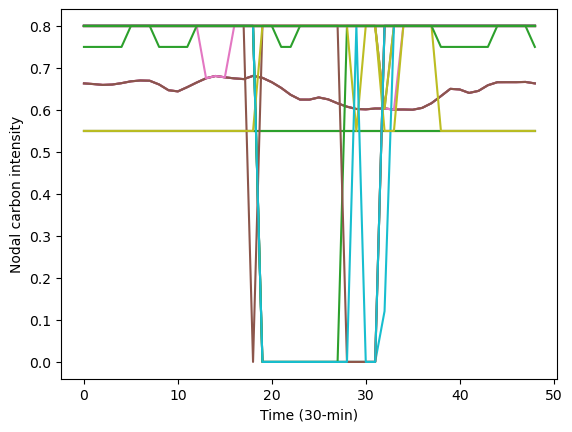

In [2]:
import matplotlib.pyplot as plt
wii = var_df(T,sets.bus,w_i)
fig, ax = plt.subplots()
ay = ax.plot(wii)
ax.set_ylabel('Nodal carbon intensity')
ax.set_xlabel('Time (30-min)')

<BarContainer object of 49 artists>

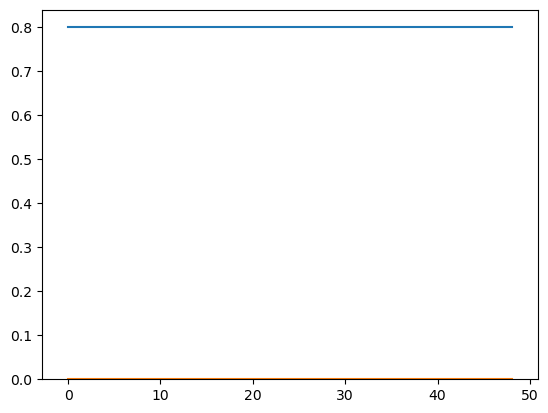

In [3]:
am = [i.X for i in w_i.select(21,'*')]
ames = [i.X for i in w_es.select(21,'*')]
ch = [i.X*1000 for i in p_ch.select(21,'*')]
dc = [i.X*1000 for i in p_dc.select(21,'*')]
comb = []
for i in range(len(ch)):
    comb.append(ch[i]-dc[i])
plt.plot(am)
plt.plot(ames)
plt.bar(sets.t,comb)

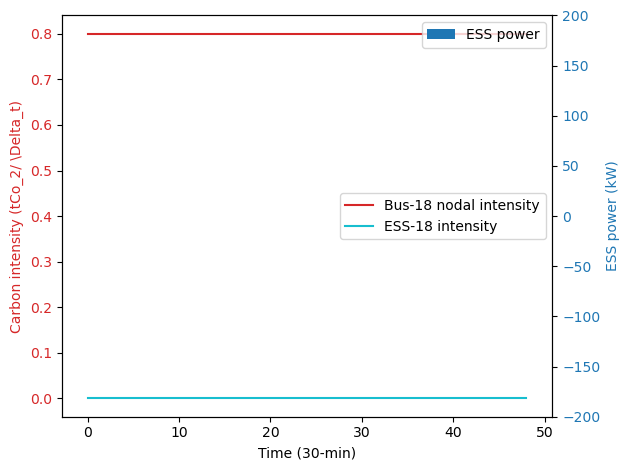

In [4]:
# import matplotlib.pyplot as plt
# import numpy as np
# plt.rcParams['text.usetex'] = True
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (30-min)')
ax1.set_ylabel('Carbon intensity (tCo_2/ \Delta_t)', color=color)
nci = ax1.plot(sets.t, am, color=color, label='Bus-18 nodal intensity')
eci = ax1.plot(sets.t, ames, color='tab:cyan', label='ESS-18 intensity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ESS power (kW)', color=color)  # we already handled the x-label with ax1
espow = ax2.bar(sets.t, comb, color=color, label='ESS power')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=-200, top=200)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

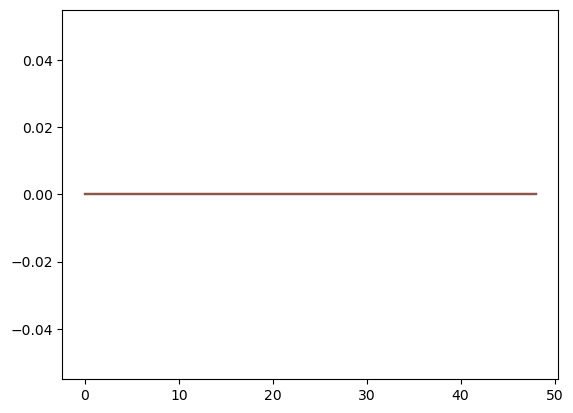

In [5]:
wess = var_df(T,sets.ess,w_es)
kek = plt.plot(wess)
np.max(wess)
plt.plot(wess)

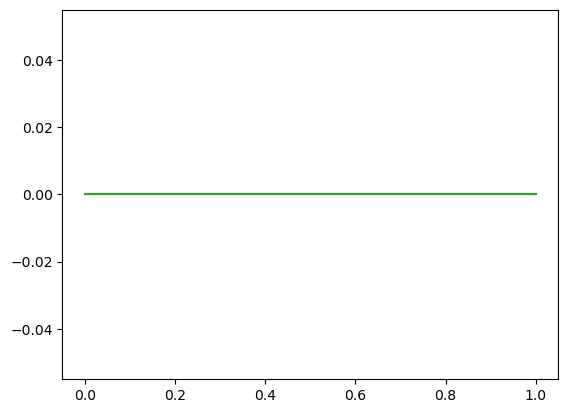

In [34]:
pcharge = var_df(T,sets.ess,p_ch)
kok = plt.plot(pcharge)

3.6826980318573836

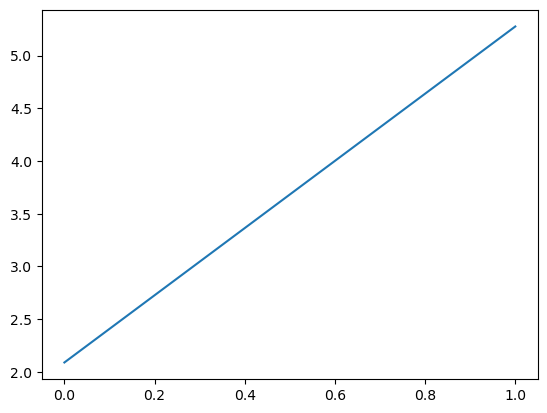

In [35]:
plosss = var_df(T,[1],ploss,1000)
plt.plot(plosss)
np.mean(plosss)

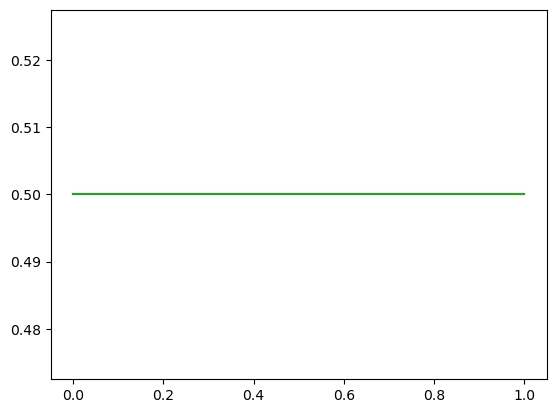

In [36]:
soc = var_df(T,sets.ess,soc_e)
plt.plot(soc)

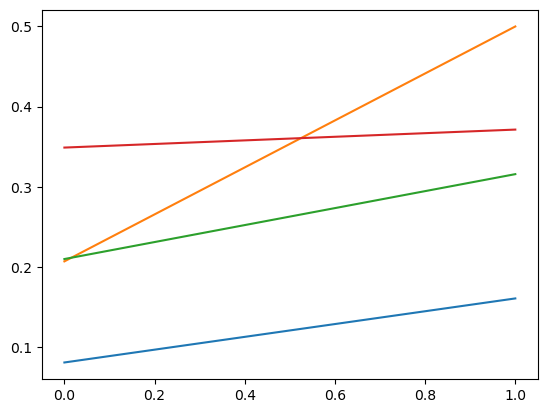

In [37]:
powergen = var_df(T,sets.gen,p_g)
plt.plot(powergen)

In [38]:
# sum(gen_emi)
# print(sum(ploss))
total_emi = var_df(T,[1],gen_emi)
sum(total_emi)*2

array([0.])

In [39]:
wess = [i.X for i in w_es.select()]
wii = [i.X for i in w_i.select(sets.ess_t)]
pcc = [i.X for i in p_ch.select()]
pdd = [i.X for i in p_dc.select()]

kk = []
for i in range(len(wess)):
    kk.append((wii[i]*pcc[i] + wess[i]*pdd[i]) * delta_t)

sum(kk)

0.0

In [40]:
# Concat variables:
class optim_result:
    def __init__(self,T):
        self.T = T

    def extract_var(x):
        return x.keys()

In [41]:
strcase = input('Give me a case name: ')
sure = input('Your case is (' + strcase + '). Are you sure? (y/n)')
if sure == 'n':
    strcase = input('Give me a case name: ')

In [42]:
# Create the directory
import os
# dirs = os.getcwd()
newfolder = './matlabdata/' + strcase
try:
    os.mkdir(newfolder)
    print(f"Directory '{newfolder}' created successfully.")
except FileExistsError:
    print(f"Directory '{newfolder}' already exists.")

Directory './matlabdata/' already exists.


In [43]:
def save_matlab(variable, dim1, set, name, strcase):
    res = var_df(dim1, set, variable)
    scipy.io.savemat('./matlabdata/' + strcase + '/' + name + '_' + strcase + '.mat', {name:res})
    return res

In [44]:
## Generator indices
res_pg = save_matlab(p_g,T,sets.gen,'p_g',strcase)
res_rg = save_matlab(r_g,T,sets.gen,'r_g',strcase)

In [45]:
##

In [46]:
## Generator indices
# res_pg = var_df(T, sets.gen, p_g)
# scipy.io.savemat('./matlabdata/p_g_'+ strcase + '.mat', dict(p_gen=res_pg))

# res_rg = var_df(T, sets.gen, r_g)
# scipy.io.savemat('./matlabdata/r_g_'+ strcase + '.mat', dict(r_gen=res_rg))

In [47]:
## ESS indices
res_pch = var_df(T, sets.ess, p_ch)
scipy.io.savemat('./matlabdata/p_ch_' + strcase + '.mat', dict(p_ch=res_pch))

res_pdc = var_df(T, sets.ess, p_dc)
scipy.io.savemat('./matlabdata/p_dc_' + strcase + '.mat', dict(p_dc=res_pdc))

res_soc = var_df(T, sets.ess, soc_e)
scipy.io.savemat('./matlabdata/soc_' + strcase + '.mat', dict(soc=res_soc))

res_w_es = var_df(T, sets.ess, w_es)
scipy.io.savemat('./matlabdata/w_es_' + strcase + '.mat', dict(w_es=res_w_es))


In [48]:
## Bus indices
res_u_i = var_df(T, sets.bus, u_i)
scipy.io.savemat('./matlabdata/u_i_' + strcase + '.mat', dict(u_i=res_u_i))

res_w_i = var_df(T, sets.bus, w_i)
scipy.io.savemat('./matlabdata/p_ch_' + strcase + '.mat', dict(w_i=res_w_i))

emi_load = np.array([w_i[i,t].X * data.bus.Pd[i] * data.load_profile[t] for i,t in sets.bus_t])
res_emi_load = emi_load.reshape(T,-1)
scipy.io.savemat('./matlabdata/emi_load_' + strcase + '.mat', dict(emi_load=res_emi_load))





In [49]:
## Line indices


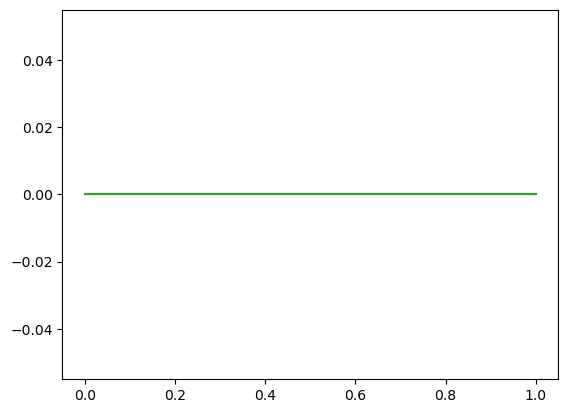

In [50]:
plt.plot(res_w_es)